# Car Price Prediction Notebook

## Data Loading

In [8]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
path = 'new_car_data.csv'
df = pd.read_csv(path)
df.sample(20)

,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,model,model_year,milage,fuel_type,ext_col,int_col,accident,price,engin_hp,engine_displacement,transmission_type,num_gears
2215,0,0,0,0,0,1,170,-0.777315,0.432595,1,0,4,0,-0.349397,0.845321,1.205223,0,-0.449229
2582,0,0,0,0,1,1,111,0.410283,-0.508119,1,0,4,0,1.005656,1.318463,1.205223,0,2.184600
1662,0,0,0,0,1,0,37,0.919253,0.323950,1,0,4,0,0.009460,-0.298465,-0.128522,0,1.396290
3027,0,0,0,0,1,1,128,-2.643540,2.314921,1,-1,1,1,-2.576525,-1.135427,-0.128522,0,-0.449229
2490,0,0,0,1,1,0,49,-1.795256,1.897305,1,0,2,0,-2.219356,-0.529567,-0.128522,0,-0.449229
2680,0,0,0,0,0,1,212,-2.304227,-0.239070,1,-1,4,0,-0.560544,-0.737871,-0.128522,0,-0.449229
1765,0,1,0,0,1,0,102,-0.098688,0.843427,1,3,4,0,-0.194377,0.340798,1.205223,0,-0.449229
1123,0,1,0,1,0,0,31,0.410283,-0.474141,1,2,4,0,-0.349397,-1.693812,-1.041045,0,2.011028
1145,1,0,0,0,1,1,19,-2.304227,2.692138,2,0,2,1,-2.193595,-0.202983,1.727343,0,-1.909811
3761,0,1,0,0,0,0,107,-0.268345,1.450768,1,0,4,1,-1.451388,-1.663939,-1.041045,0,-0.449229


## Feature Engineering

In [9]:
df['car_age'] = 2024 - df['model_year']
df.drop(columns=['ext_col'], inplace=True, axis=1)
df['age_mileage_interaction'] = df['car_age'] * df['milage']
df['avg_hp_by_year'] = df.groupby('model_year')['engin_hp'].transform('mean')

### Mileage Features

In [10]:
df['model_milage_avg'] = df.groupby('model')['milage'].transform('mean')
df['milage_minus_model_avg'] = df['milage'] - df['model_milage_avg']
df['milage_percentile'] = df['milage'].rank(pct=True)

## Train/Test Split

In [11]:
df.info()
print(df.isna().sum())
X = df.drop(columns=['price'], axis=1)
y = df['price']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=42, random_state=42)
df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   brand_0                  4009 non-null   int64  
 1   brand_1                  4009 non-null   int64  
 2   brand_2                  4009 non-null   int64  
 3   brand_3                  4009 non-null   int64  
 4   brand_4                  4009 non-null   int64  
 5   brand_5                  4009 non-null   int64  
 6   model                    4009 non-null   int64  
 7   model_year               4009 non-null   float64
 8   milage                   4009 non-null   float64
 9   fuel_type                4009 non-null   int64  
 10  int_col                  4009 non-null   int64  
 11  accident                 4009 non-null   int64  
 12  price                    4009 non-null   float64
 13  engin_hp                 4009 non-null   float64
 14  engine_displacement     

,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5,model,model_year,milage,fuel_type,...,engin_hp,engine_displacement,transmission_type,num_gears,car_age,age_mileage_interaction,avg_hp_by_year,model_milage_avg,milage_minus_model_avg,milage_percentile
0,0,0,0,0,0,1,1,-0.438002,0.002427,4,...,-0.202983,-0.128522,0,-0.449229,2024.438002,4.9137,-0.181328,-0.273202,0.275629,0.486031


## Baseline Model Comparison

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def check_all_models(x_train, x_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'K-Nearest Neighbors': KNeighborsRegressor(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'Gradient Boosting': GradientBoostingRegressor(),
        'AdaBoost': AdaBoostRegressor(),
        'XGBoost': XGBRegressor(),
        'XGB Random Forest': XGBRFRegressor(),
    }
    results = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        train_r2 = model.score(x_train, y_train)
        test_r2  = model.score(x_test, y_test)
        mae      = mean_absolute_error(y_test, preds)
        mse      = mean_squared_error(y_test, preds)
        rmse     = np.sqrt(mse)
        results.append({
            'Model': name,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'Overfitting': test_r2 < train_r2,
            'Underfitting': train_r2 < 0.5 and test_r2 < 0.5
        })
    display(pd.DataFrame(results))

check_all_models(x_train, x_test, y_train, y_test)

,Model,Train R²,Test R²,MAE,MSE,RMSE,Overfitting,Underfitting
0,Linear Regression,0.770898,0.745990,0.351663,0.209824,0.458066,True,False
1,K-Nearest Neighbors,0.658990,0.368006,0.543975,0.522056,0.722534,True,False
2,Decision Tree,1.000000,0.674239,0.353870,0.269093,0.518742,True,False
3,Random Forest,0.977632,0.801429,0.284982,0.164029,0.405004,True,False
4,Gradient Boosting,0.861635,0.800135,0.283261,0.165098,0.406322,True,False
5,AdaBoost,0.750821,0.686312,0.396476,0.259120,0.509038,True,False
6,XGBoost,0.986755,0.865882,0.226549,0.110787,0.332847,True,False
7,XGB Random Forest,0.829820,0.756762,0.312500,0.200926,0.448248,True,False


## XGBoost Quick Tuning

In [13]:
import xgboost as xgb
from xgboost import XGBRegressor

model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    n_estimators=1000,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    learning_rate=0.05,
    random_state=42
)
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
print(model.best_iteration)
print(model.best_score)
print(model.score(x_test, y_test))
dtrain = xgb.DMatrix(X, label=y)
params = model.get_xgb_params()
cv_results = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, metrics=('rmse',), early_stopping_rounds=50, as_pandas=True, seed=42)
len(cv_results)

372
0.38386243714080537
0.8216195416274314


546

## Optuna Hyperparameter Tuning

In [15]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int("n_estimators", 1000,1200),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
        'gamma': trial.suggest_float("gamma", 0, 0.5),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'reg_alpha': trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        'random_state': 42,
        'eval_metric': 'rmse',
        'early_stopping_rounds': 50
    }
    m = XGBRegressor(**params)
    m.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
    preds = m.predict(x_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, n_jobs=-1)
print(study.best_value)
print(study.best_params)

[I 2025-04-19 08:23:13,121] A new study created in memory with name: no-name-a876a0c2-df8d-47c8-9f3d-4a87e09a439f
[I 2025-04-19 08:23:14,657] Trial 3 finished with value: 0.3851468426822524 and parameters: {'n_estimators': 1110, 'learning_rate': 0.05882439981151378, 'max_depth': 6, 'min_child_weight': 10, 'gamma': 0.2648436078964272, 'subsample': 0.6631014636805556, 'colsample_bytree': 0.9562948554801328, 'reg_alpha': 0.010903015061263973, 'reg_lambda': 7.724059429300092e-05}. Best is trial 3 with value: 0.3851468426822524.
[I 2025-04-19 08:23:14,789] Trial 1 finished with value: 0.39497305750757283 and parameters: {'n_estimators': 1065, 'learning_rate': 0.033758427304023064, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.3700659835900715, 'subsample': 0.9996591741420104, 'colsample_bytree': 0.681588741562943, 'reg_alpha': 0.008971429509589898, 'reg_lambda': 0.014421546867472566}. Best is trial 3 with value: 0.3851468426822524.
[I 2025-04-19 08:23:14,824] Trial 0 finished with value

0.2881971924658819
{'n_estimators': 1069, 'learning_rate': 0.22775356240627817, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 0.10023856368447331, 'subsample': 0.6179437749868162, 'colsample_bytree': 0.7889413642934179, 'reg_alpha': 0.004351681213241297, 'reg_lambda': 0.3339461055280027}


## Final Model and Evaluation

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
import joblib

best_model = XGBRegressor(
    **study.best_params,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50,
    random_state=42
)
best_model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)
train_preds = best_model.predict(x_train)
test_preds  = best_model.predict(x_test)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse  = np.sqrt(mean_squared_error(y_test, test_preds))
train_r2   = r2_score(y_train, train_preds)
test_r2    = r2_score(y_test, test_preds)
print("Train RMSE : ",train_rmse)
print("Test RMSE : ",test_rmse)
print("Train R2 : ",train_r2)
print("Test R2 : ",test_r2)



Train RMSE :  0.21003660137488425
Test RMSE :  0.2881971924658819
Train R2 :  0.9559530075103699
Test R2 :  0.8994515133403655


## Model Explainability & Prediction Visualization

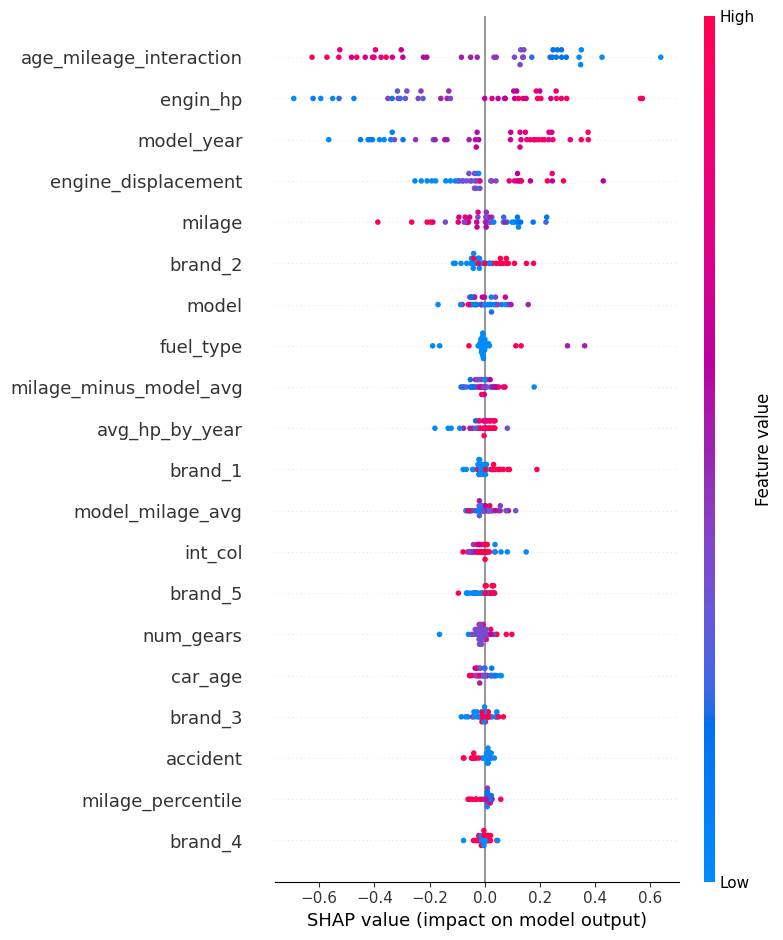

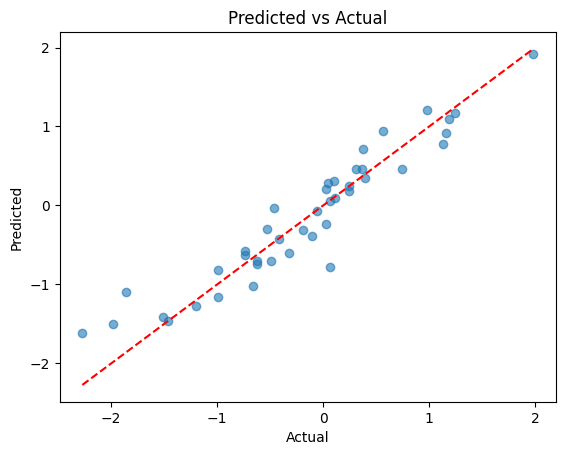

In [18]:
explainer = shap.Explainer(best_model)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test)
plt.scatter(y_test, test_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

## Saving The Best Model

In [19]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

## End of Notebook

In [20]:
print("Notebook execution finished")

Notebook execution finished
